In [42]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from PIL import Image
import pandas as pd
import os
import json

# Function to load idx2word and convert it to word2idx
def load_vocabulary(path):
    with open(path, 'r') as file:
        idx2word = json.load(file)
    word2idx = {v: int(k) for k, v in idx2word.items()}
    return idx2word, word2idx

# Load vocabulary
idx2word_path = '/home/vitoupro/code/image_captioning/data/processed/idx2word.json'
idx2word, word2idx = load_vocabulary(idx2word_path)

# Encoding function for Khmer characters
def encode_khmer_word(word, word2idx):
    indices = []
    for character in word:
        index = word2idx.get(character)
        if index is None:
            return None, f"Character '{character}' not found in vocabulary!"
        indices.append(index)
    return indices, None

# Decoding function for indices to Khmer characters
def decode_indices(indices, idx2word):
    characters = []
    for index in indices:
        character = idx2word.get(str(index))  # Ensure index is converted to string
        if character is None:
            return None, f"Index '{index}' not found in idx2word!"
        characters.append(character)
    return ''.join(characters), None

# Define the Encoder CNN
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        modules = list(resnet.children())[:-1]  # Remove the last layer
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.embed(features)
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.num_layers = num_layers  # Ensure this is properly defined
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        h0 = features.unsqueeze(0).repeat(self.num_layers, 1, 1)  # Using num_layers correctly here
        c0 = torch.zeros_like(h0)  # Correctly creates a zero tensor for LSTM cell state
        lstm_out, _ = self.lstm(embeddings, (h0, c0))
        outputs = self.linear(lstm_out)
        return outputs


class ImageCaptionDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, vocab, transform=None, max_length=50):
        self.img_labels = pd.read_csv(annotations_file, delimiter=' ', names=['image', 'caption'])
        self.img_dir = img_dir
        self.vocab = vocab
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        caption = self.img_labels.iloc[idx, 1]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        indices, error = encode_khmer_word(caption, self.vocab)
        if error:
            print(f"Error encoding caption: {error}")  # More detailed error reporting
            indices = [self.vocab['<UNK>']] * self.max_length

        tokens = [self.vocab['<START>']] + indices + [self.vocab['<END>']]
        tokens += [self.vocab['<PAD>']] * (self.max_length - len(tokens))
        return image, torch.tensor(tokens[:self.max_length])


# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Create dataset and data loader
dataset = ImageCaptionDataset(
    annotations_file='/home/vitoupro/code/image_captioning/data/raw/annotation.txt',
    img_dir='/home/vitoupro/code/image_captioning/data/raw/animals',
    vocab=word2idx,
    transform=transform,
    max_length=20
)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the models
encoder = EncoderCNN(embed_size=512).to(device)
decoder = DecoderRNN(embed_size=256, hidden_size=512, vocab_size=len(word2idx), num_layers=1).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<PAD>'])
params = list(decoder.parameters()) + list(encoder.embed.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)


/home/vitoupro/code/image_captioning/image_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vitoupro/code/image_captioning/image_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Original text: <START>មេអំបៅ<END><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
Encoded data: tensor([ 1, 28, 67, 38, 72, 24, 71,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0])
Decoded data: <START>មេអំបៅ<END><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>


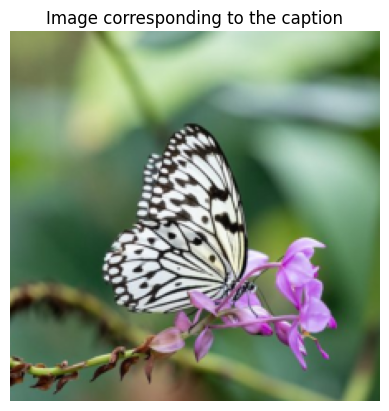

In [52]:
import matplotlib.pyplot as plt

def print_sample_caption_by_index(dataloader, idx2word, word2idx, sample_index):
    # Fetch the first batch of data
    dataiter = iter(dataloader)
    images, captions = next(dataiter)  # Include images this time

    # Get the image and caption for the specified index
    image = images[sample_index]
    caption_indices = captions[sample_index]

    # Decode the caption indices to text
    decoded_caption, decode_error = decode_indices(caption_indices.tolist(), idx2word)
    
    # Retrieve the original text (assuming it's already decoded in the dataset for comparison)
    original_text = decode_indices(captions[sample_index].tolist(), idx2word)[0]

    # Print original, encoded, and decoded captions
    print("Original text:", original_text)
    print("Encoded data:", caption_indices)
    if decode_error:
        print("Error decoding data:", decode_error)
    else:
        print("Decoded data:", decoded_caption)
    
    # Display the image
    plt.imshow(image.permute(1, 2, 0))  # Adjust dimension order for matplotlib
    plt.axis('off')  # Turn off axis
    plt.title("Image corresponding to the caption")
    plt.show()

# Call the function specifying the index of the image you want to inspect
print_sample_caption_by_index(dataloader, idx2word, word2idx, 5)  # For the first image


In [34]:
import torch

# Assume device configuration and models (encoder, decoder), criterion, optimizer are already defined

# Specify the number of epochs you want to train
num_epochs = 10

# Start the training loop
for epoch in range(num_epochs):
    total_loss = 0  # Initialize total loss to zero for each epoch
    num_batches = 0  # Counter for batches, used for average loss calculation

    # Iterate over data in the dataloader
    for images, captions in dataloader:
        images, captions = images.to(device), captions.to(device)  # Move data to the appropriate device (GPU or CPU)

        # Forward pass: compute the encoder outputs
        features = encoder(images)  # Encode images to features

        # Forward pass: compute the predicted captions by the decoder
        outputs = decoder(features, captions[:, :-1])  # Exclude the <END> token from inputs to the decoder

        # Calculate the loss based on the outputs from the decoder and the actual captions
        loss = criterion(outputs.view(-1, len(word2idx)), captions[:, 1:].reshape(-1))  # Reshape for calculating loss

        # Backward pass: compute the gradient of the loss with respect to model parameters
        optimizer.zero_grad()  # Reset the gradients to zero before starting to do backpropagation
        loss.backward()  # Backpropagation: calculate the gradients

        # Update the model parameters
        optimizer.step()  # Adjust weights based on calculated gradients

        total_loss += loss.item()  # Accumulate the loss
        num_batches += 1  # Increment the batch counter

    # Calculate average loss over all batches in the dataloader
    average_loss = total_loss / num_batches if num_batches > 0 else 0

    # Print the average loss for this epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss:.4f}')


Epoch 1/10, Average Loss: 1.1030
Epoch 2/10, Average Loss: 0.4299
Epoch 3/10, Average Loss: 0.2603
Epoch 4/10, Average Loss: 0.1679
Epoch 5/10, Average Loss: 0.1137
Epoch 6/10, Average Loss: 0.0930
Epoch 7/10, Average Loss: 0.0780
Epoch 8/10, Average Loss: 0.0700
Epoch 9/10, Average Loss: 0.0642
Epoch 10/10, Average Loss: 0.0590


In [36]:
# Save the model state dictionary
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'captioning_model.pth')
